
## Data Importing



In [83]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.filterwarnings("ignore")

In [84]:
train_path = ".\\Data\\train"
val_path = ".\\Data\\valid"
test_path = ".\\Data\\test"


In [85]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


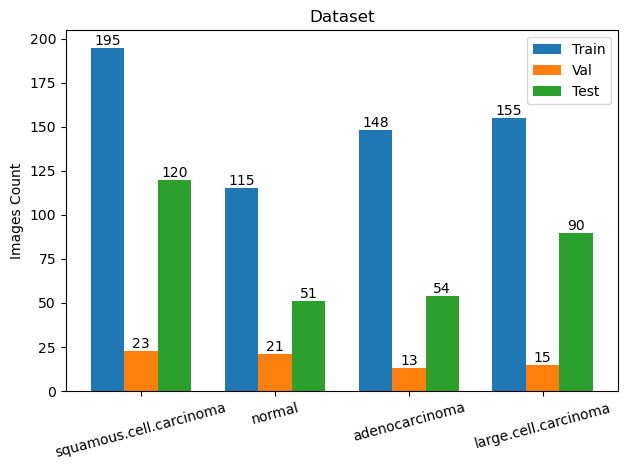

In [86]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()


In [87]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [88]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range=0.2,
                                   shear_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                               batch_size = 5,
                                               target_size = (350,350),
                                               class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [89]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [90]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                           batch_size = 5,
                                           target_size = (350,350),
                                           class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [91]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [92]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                             batch_size = 5,
                                             target_size = (350,350),
                                             class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [93]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

## PCA

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy


# Extract images and labels from the generators
def extract_images_and_labels(data_gen):
    data, labels = [], []
    num_samples = len(data_gen)
    for _ in range(num_samples):
        img, label = data_gen.next()
        data.append(img)
        labels.append(label)
    data = np.concatenate(data, axis=0)
    
    # Concatenate labels correctly
    labels = np.concatenate(labels, axis=0)
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    
    return data, labels



train_images, train_labels = extract_images_and_labels(train_data)
val_images, val_labels = extract_images_and_labels(val_data)
test_images, test_labels = extract_images_and_labels(test_data)

# Flatten the images for PCA
n_samples, h, w, c = train_images.shape
train_images_flat = train_images.reshape(n_samples, h * w * c)
val_images_flat = val_images.reshape(len(val_images), h * w * c)
test_images_flat = test_images.reshape(len(test_images), h * w * c)

# Standardizing the features
scaler = StandardScaler().fit(train_images_flat)
train_images_flat = scaler.transform(train_images_flat)
val_images_flat = scaler.transform(val_images_flat)
test_images_flat = scaler.transform(test_images_flat)

# PCA transformation
pca = PCA(n_components=0.95)  # keeping 95% of variance
train_pca = pca.fit_transform(train_images_flat)
val_pca = pca.transform(val_images_flat)
test_pca = pca.transform(test_images_flat)


## basic models

Model: Logistic Regression
Training Accuracy: 1.0000
Validation Accuracy: 0.3472
Test Accuracy: 0.4190
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       120
           1       0.39      0.22      0.28        51
           2       0.95      0.72      0.82        54
           3       0.29      0.30      0.30        90

    accuracy                           0.42       315
   macro avg       0.50      0.42      0.45       315
weighted avg       0.45      0.42      0.42       315



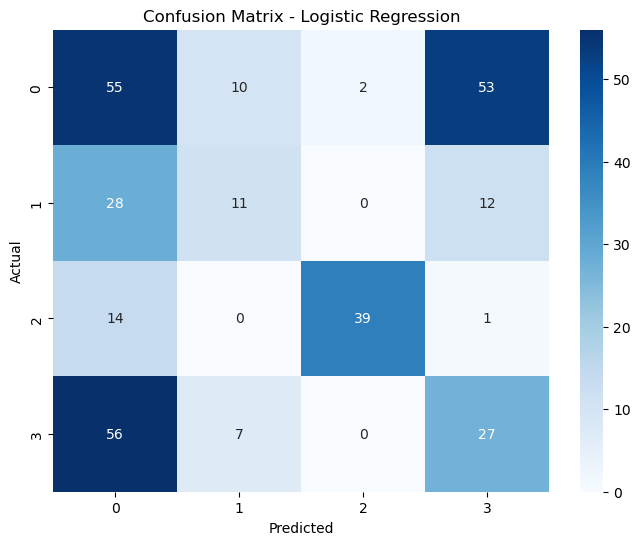

Model: Support Vector Machine
Training Accuracy: 0.7504
Validation Accuracy: 0.4444
Test Accuracy: 0.5397
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.47      0.93      0.62       120
           1       0.00      0.00      0.00        51
           2       1.00      0.93      0.96        54
           3       0.31      0.10      0.15        90

    accuracy                           0.54       315
   macro avg       0.45      0.49      0.43       315
weighted avg       0.44      0.54      0.45       315



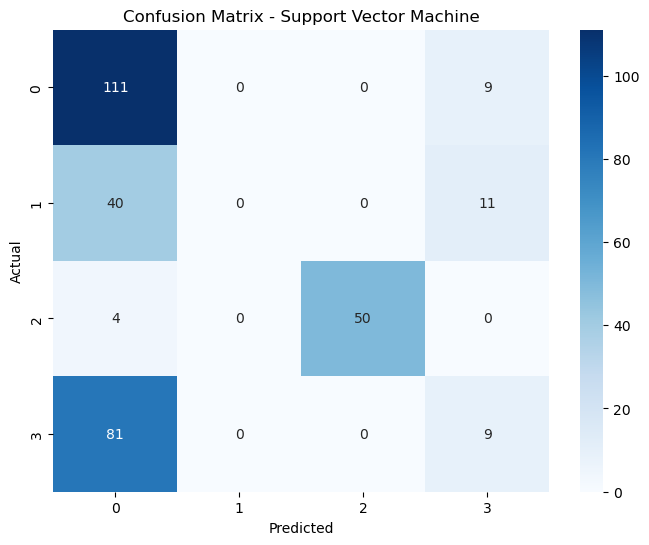

Model: Random Forest
Training Accuracy: 1.0000
Validation Accuracy: 0.4167
Test Accuracy: 0.4190
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.38      0.59      0.46       120
           1       0.20      0.02      0.04        51
           2       1.00      0.67      0.80        54
           3       0.28      0.27      0.27        90

    accuracy                           0.42       315
   macro avg       0.46      0.39      0.39       315
weighted avg       0.43      0.42      0.40       315



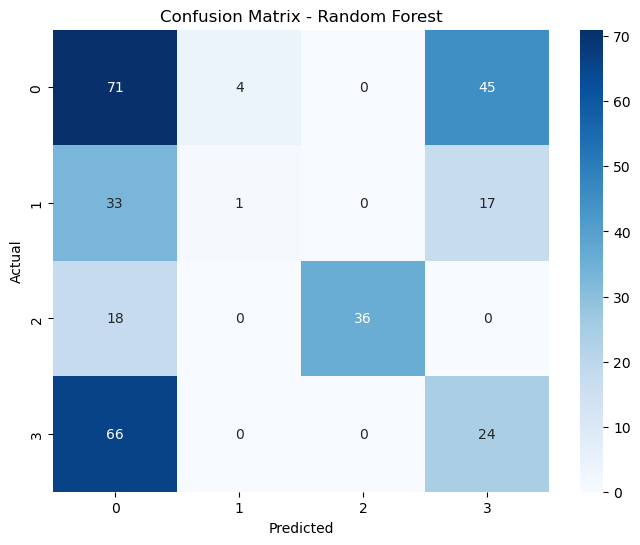

Model: Gradient Boosting
Training Accuracy: 1.0000
Validation Accuracy: 0.3750
Test Accuracy: 0.3905
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.34      0.38      0.36       120
           1       0.24      0.16      0.19        51
           2       1.00      0.50      0.67        54
           3       0.35      0.47      0.40        90

    accuracy                           0.39       315
   macro avg       0.48      0.38      0.40       315
weighted avg       0.44      0.39      0.40       315



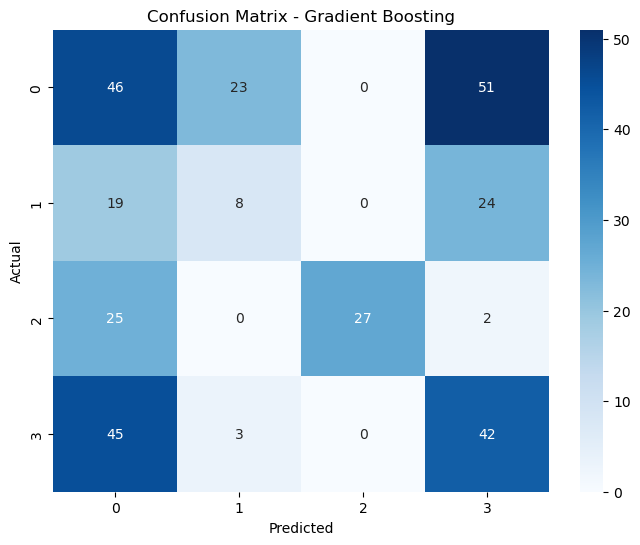

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(train_pca, train_labels)
    
    # Predictions
    train_preds = model.predict(train_pca)
    val_preds = model.predict(val_pca)
    test_preds = model.predict(test_pca)
    
    # Evaluation metrics
    train_accuracy = accuracy_score(train_labels, train_preds)
    val_accuracy = accuracy_score(val_labels, val_preds)
    test_accuracy = accuracy_score(test_labels, test_preds)
    
    print(f"Model: {name}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print("Classification Report (Test Data):")
    print(classification_report(test_labels, test_preds))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## Addition of knn Decision tree and multilayer perceptron

Model: Logistic Regression
Training Accuracy: 1.0000
Validation Accuracy: 0.3472
Test Accuracy: 0.4190
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       120
           1       0.39      0.22      0.28        51
           2       0.95      0.72      0.82        54
           3       0.29      0.30      0.30        90

    accuracy                           0.42       315
   macro avg       0.50      0.42      0.45       315
weighted avg       0.45      0.42      0.42       315



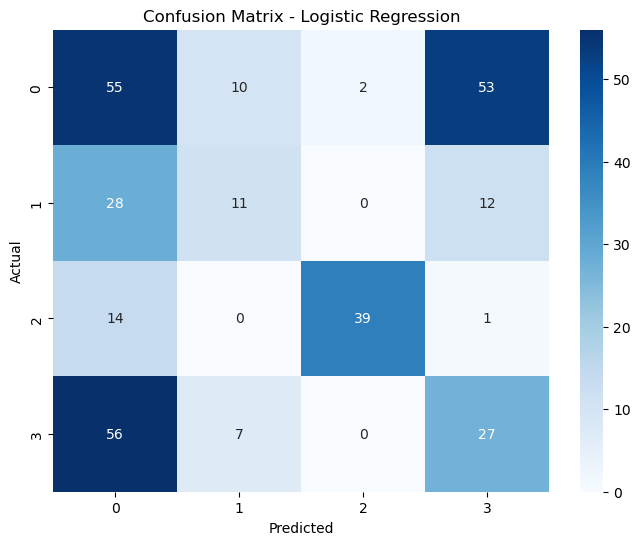

Model: Support Vector Machine
Training Accuracy: 0.7504
Validation Accuracy: 0.4444
Test Accuracy: 0.5397
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.47      0.93      0.62       120
           1       0.00      0.00      0.00        51
           2       1.00      0.93      0.96        54
           3       0.31      0.10      0.15        90

    accuracy                           0.54       315
   macro avg       0.45      0.49      0.43       315
weighted avg       0.44      0.54      0.45       315



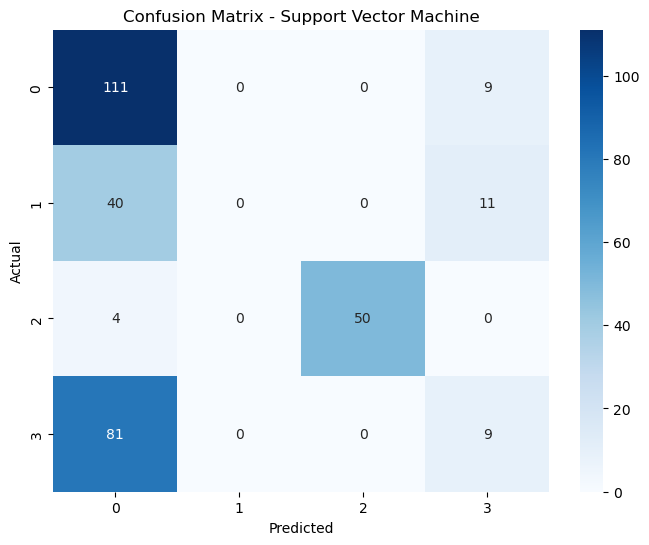

Model: Random Forest
Training Accuracy: 1.0000
Validation Accuracy: 0.4167
Test Accuracy: 0.4825
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.44      0.71      0.54       120
           1       0.25      0.04      0.07        51
           2       1.00      0.61      0.76        54
           3       0.40      0.36      0.37        90

    accuracy                           0.48       315
   macro avg       0.52      0.43      0.44       315
weighted avg       0.49      0.48      0.45       315



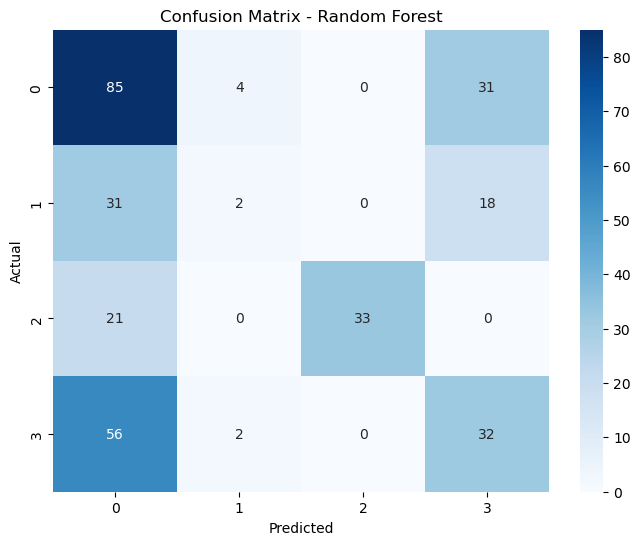

Model: Gradient Boosting
Training Accuracy: 1.0000
Validation Accuracy: 0.3750
Test Accuracy: 0.3873
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.34      0.38      0.36       120
           1       0.23      0.16      0.19        51
           2       1.00      0.50      0.67        54
           3       0.35      0.46      0.39        90

    accuracy                           0.39       315
   macro avg       0.48      0.37      0.40       315
weighted avg       0.44      0.39      0.39       315



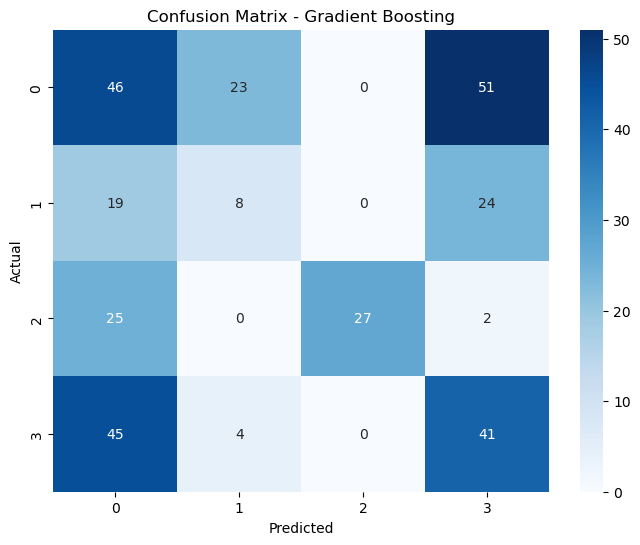

Model: K-Nearest Neighbors
Training Accuracy: 0.6020
Validation Accuracy: 0.2500
Test Accuracy: 0.3841
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.39      0.61      0.48       120
           1       0.29      0.49      0.36        51
           2       1.00      0.20      0.34        54
           3       0.38      0.13      0.20        90

    accuracy                           0.38       315
   macro avg       0.51      0.36      0.34       315
weighted avg       0.48      0.38      0.36       315



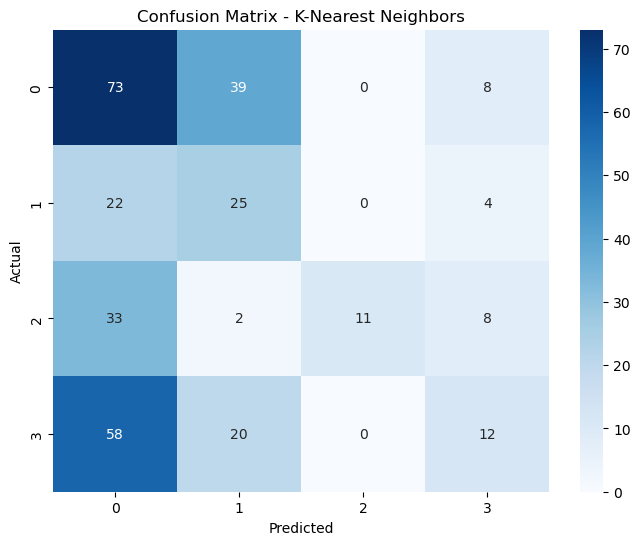

Model: Decision Tree
Training Accuracy: 1.0000
Validation Accuracy: 0.3750
Test Accuracy: 0.3873
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       120
           1       0.15      0.18      0.16        51
           2       0.96      0.93      0.94        54
           3       0.26      0.24      0.25        90

    accuracy                           0.39       315
   macro avg       0.43      0.42      0.43       315
weighted avg       0.39      0.39      0.39       315



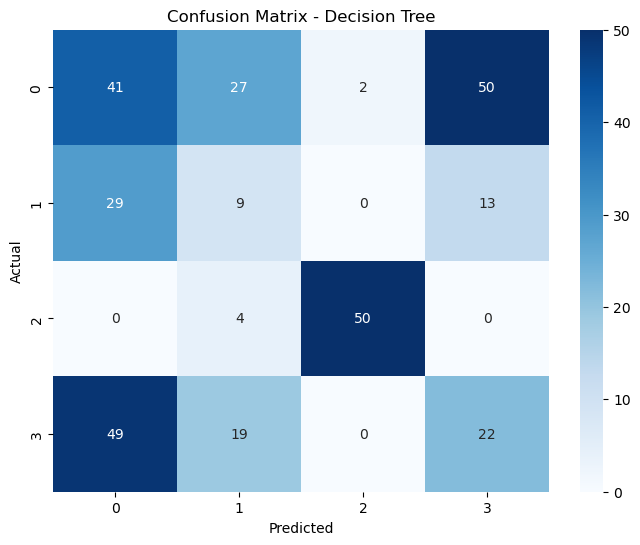

Model: Multilayer Perceptron
Training Accuracy: 1.0000
Validation Accuracy: 0.3750
Test Accuracy: 0.3587
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.46      0.33      0.38       120
           1       0.26      0.29      0.28        51
           2       0.46      0.48      0.47        54
           3       0.29      0.37      0.32        90

    accuracy                           0.36       315
   macro avg       0.37      0.37      0.36       315
weighted avg       0.38      0.36      0.36       315



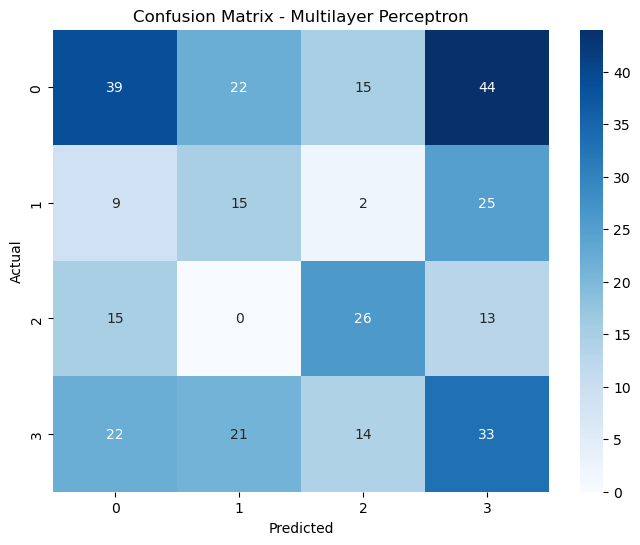

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Add models
models.update({
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Multilayer Perceptron": MLPClassifier()
})
dic={}
# Train and evaluate models (continued)
for name, model in models.items():
    # Train the model
    model.fit(train_pca, train_labels)
    
    # Predictions
    train_preds = model.predict(train_pca)
    val_preds = model.predict(val_pca)
    test_preds = model.predict(test_pca)
    
    # Evaluation metrics
    train_accuracy = accuracy_score(train_labels, train_preds)
    val_accuracy = accuracy_score(val_labels, val_preds)
    test_accuracy = accuracy_score(test_labels, test_preds)
    
    print(f"Model: {name}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print("Classification Report (Test Data):")
    print(classification_report(test_labels, test_preds))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    dic[name]=accuracy_score(test_labels, test_preds)


## setting parameters for Gradient decent Hyperparameters

In [125]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'max_iter': [50,75, 100, 125, 200],  # Number of iterations
}

# Initialize the SGDClassifier
sgd_classifier = SGDClassifier(loss='perceptron', random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=sgd_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(train_pca, train_labels)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'alpha': 0.1, 'learning_rate': 'optimal', 'max_iter': 75}


## training the gradient decent with percepron loss

Gradient Descent Classifier:
Training Accuracy: 0.7015
Validation Accuracy: 0.3611
Test Accuracy: 0.4127
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.40      0.80      0.53       120
           1       0.00      0.00      0.00        51
           2       0.84      0.48      0.61        54
           3       0.19      0.09      0.12        90

    accuracy                           0.41       315
   macro avg       0.36      0.34      0.32       315
weighted avg       0.35      0.41      0.34       315



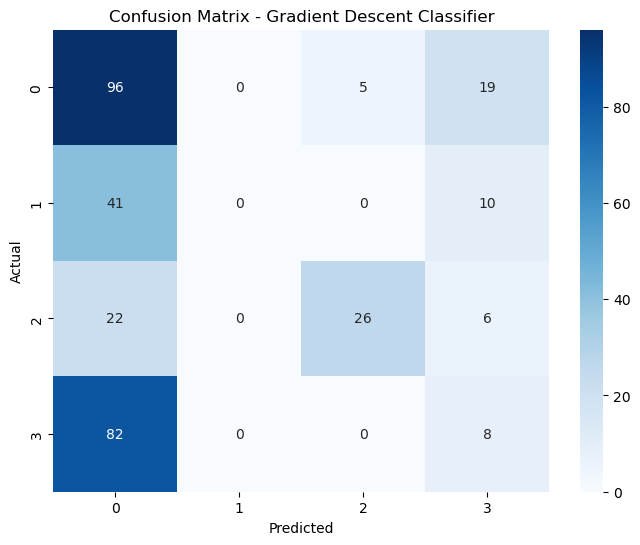

In [126]:
from sklearn.linear_model import SGDClassifier

# Define and train Gradient Descent (SGDClassifier)
# Define and train Gradient Descent (SGDClassifier) with squared_error loss
from sklearn.metrics import accuracy_score

# Initialize SGDClassifier with best hyperparameters
sgd_classifier = SGDClassifier(loss='perceptron', alpha=0.1, learning_rate='optimal', max_iter=75, random_state=42)

# Train the model
sgd_classifier.fit(train_pca, train_labels)



# Predictions
train_preds_sgd = sgd_classifier.predict(train_pca)
val_preds_sgd = sgd_classifier.predict(val_pca)
test_preds_sgd = sgd_classifier.predict(test_pca)

# Evaluation metrics for Gradient Descent
train_accuracy_sgd = accuracy_score(train_labels, train_preds_sgd)
val_accuracy_sgd = accuracy_score(val_labels, val_preds_sgd)
test_accuracy_sgd = accuracy_score(test_labels, test_preds_sgd)
   

print("Gradient Descent Classifier:")
print(f"Training Accuracy: {train_accuracy_sgd:.4f}")
print(f"Validation Accuracy: {val_accuracy_sgd:.4f}")
print(f"Test Accuracy: {test_accuracy_sgd:.4f}")
print("Classification Report (Test Data):")
print(classification_report(test_labels, test_preds_sgd))
# Confusion matrix for Gradient Descent
plt.figure(figsize=(8, 6))
cm_sgd = confusion_matrix(test_labels, test_preds_sgd)
sns.heatmap(cm_sgd, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.title("Confusion Matrix - Gradient Descent Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



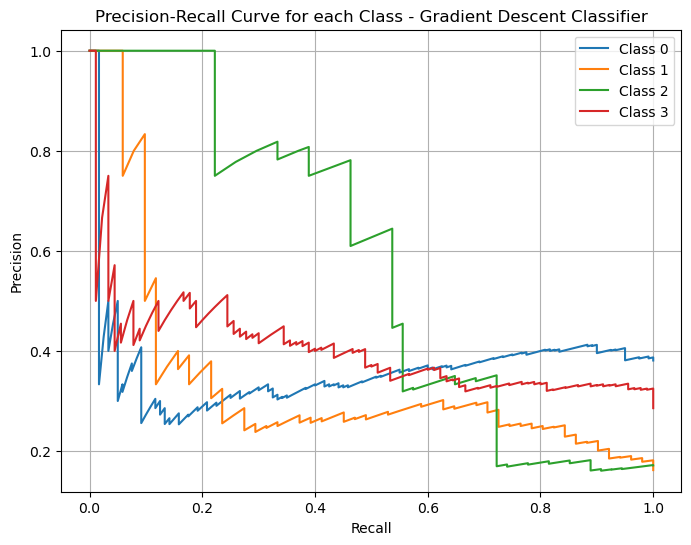

In [99]:
from sklearn.metrics import precision_recall_curve

# Compute precision and recall for each class
precisions = dict()
recalls = dict()
thresholds = dict()

for i in range(4):  # num_classes is the number of classes in your dataset
    precisions[i], recalls[i], thresholds[i] = precision_recall_curve(test_labels == i, sgd_classifier.decision_function(test_pca)[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(recalls[i], precisions[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each Class - Gradient Descent Classifier')
plt.legend()
plt.grid(True)
plt.show()



In [100]:
model = Sequential() 

# Convolutional Layer with input shape (350,350,3)
model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(350,350,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=4, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 348, 348, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 346, 346, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 173, 173, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 171, 171, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 85, 85, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 83, 83, 128)      

## Start of CNN

In [101]:
mc = ModelCheckpoint(
    filepath="./ct_cnn_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [102]:
cnn = model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32


122/122 [==============================] - ETA: 0s - loss: 1.4139 - accuracy: 0.3882
Epoch 1: val_accuracy improved from -inf to 0.38571, saving model to .\ct_cnn_best_model.hdf5
122/122 [==============================] - 111s 896ms/step - loss: 1.4139 - accuracy: 0.3882 - val_loss: 1.0559 - val_accuracy: 0.3857
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.4720
Epoch 2: val_accuracy did not improve from 0.38571
122/122 [==============================] - 109s 896ms/step - loss: 1.1219 - accuracy: 0.4720 - val_loss: 1.0580 - val_accuracy: 0.3429
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.4885
Epoch 3: val_accuracy improved from 0.38571 to 0.45714, saving model to .\ct_cnn_best_model.hdf5
122/122 [==============================] - 111s 906ms/step - loss: 1.0516 - accuracy: 0.4885 - val_loss: 1.0259 - val_accuracy: 0.4571
Epoch 4/32
122/122 [==============================] - ETA: 0s -

In [103]:
model = load_model("./ct_cnn_best_model.hdf5")

In [104]:
accuracy_cnn = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_cnn*100} %")

The accuracy of the model is = 56.82539939880371 %


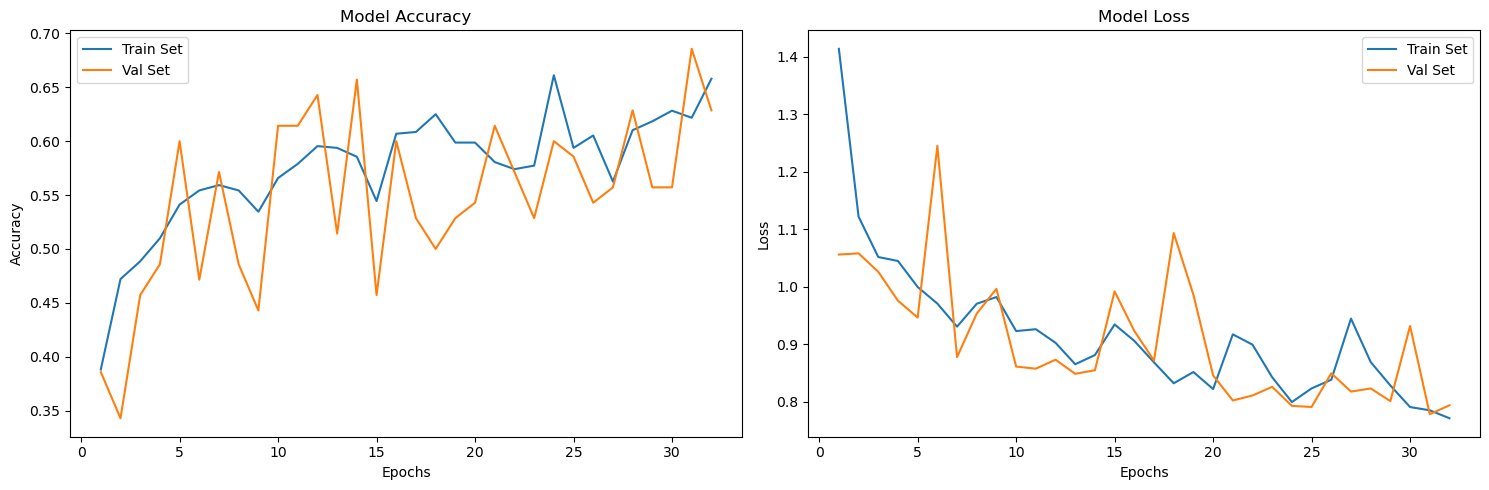

In [105]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']
epochs_range = range(1, len(cnn.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


## ResNet 50 

In [106]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet", 
                      pooling='max')

94765736/94765736 [==============================] - 9s 0us/step


In [107]:
for layer in base_model.layers:
    layer.trainable = False

In [108]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [109]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [110]:
mc = ModelCheckpoint(
    filepath="./ct_resnet_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [115]:

resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.4995 - accuracy: 0.3273
Epoch 1: val_accuracy improved from -inf to 0.48571, saving model to .\ct_resnet_model.hdf5
122/122 [==============================] - 90s 697ms/step - loss: 1.4995 - accuracy: 0.3273 - val_loss: 1.4094 - val_accuracy: 0.4857
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.2445 - accuracy: 0.4276
Epoch 2: val_accuracy did not improve from 0.48571
122/122 [==============================] - 82s 669ms/step - loss: 1.2445 - accuracy: 0.4276 - val_loss: 1.1916 - val_accuracy: 0.4000
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.1713 - accuracy: 0.4622
Epoch 3: val_accuracy improved from 0.48571 to 0.50000, saving model to .\ct_resnet_model.hdf5
122/122 [==============================] - 85s 695ms/step - loss: 1.1713 - accuracy: 0.4622 - val_loss: 1.1537 - val_accuracy: 0.5000
Epoch 4/32
122/122 [==============================] - ETA: 0s - loss: 1.

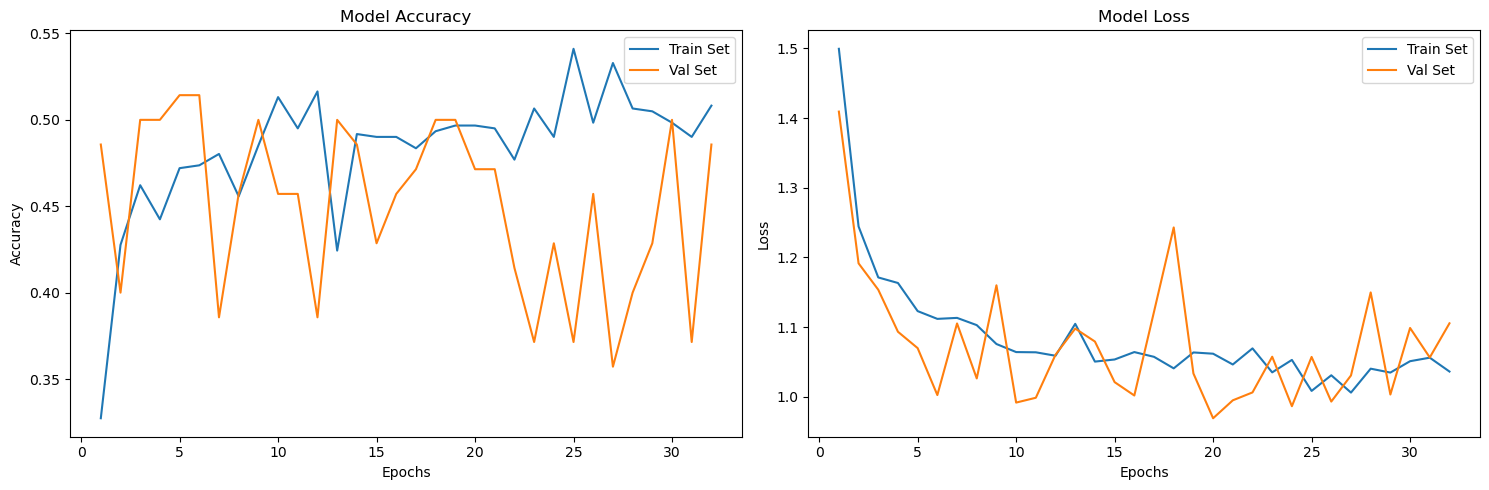

In [116]:
acc = resnet.history['accuracy']
val_acc = resnet.history['val_accuracy']
loss = resnet.history['loss']
val_loss = resnet.history['val_loss']
epochs_range = range(1, len(resnet.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [117]:
model = load_model("./ct_resnet_model.hdf5")

accuracy_resnet = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_resnet*100} %")

The accuracy of the model is = 53.015875816345215 %


## Final evaluation metric across all models 

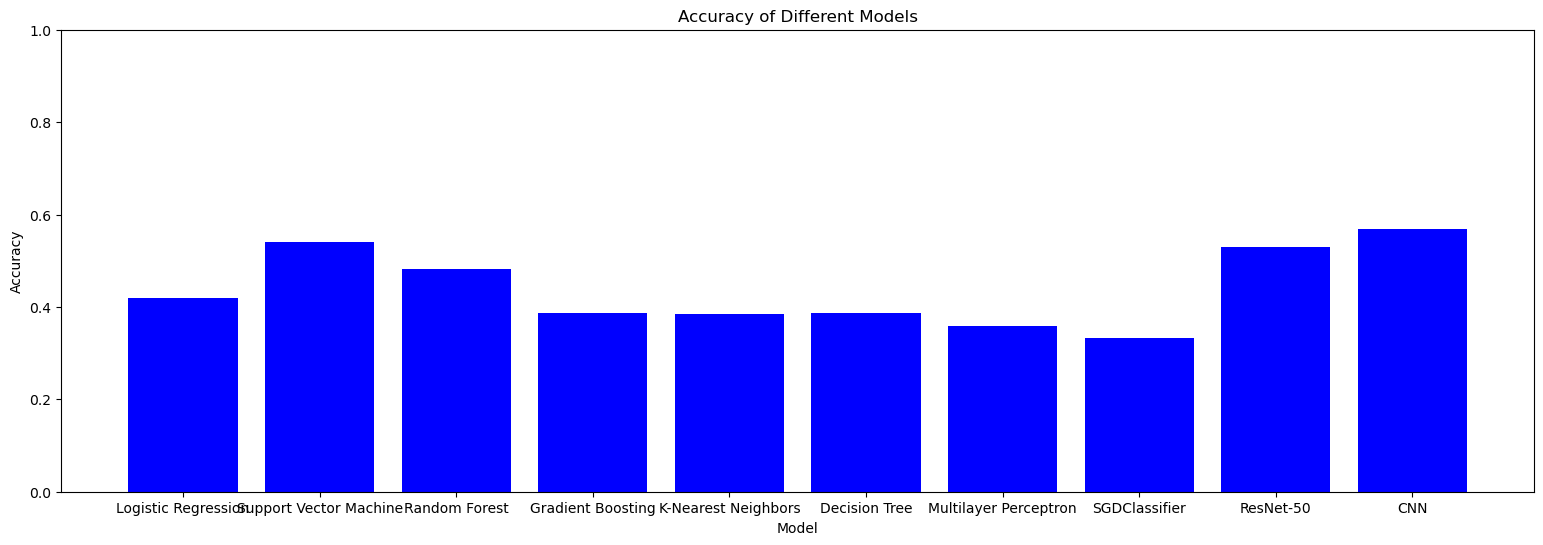

In [123]:
import matplotlib.pyplot as plt

# Define the dictionary with model names and their accuracies

dic['SGDClassifier']=test_accuracy_sgd
dic['ResNet-50']=accuracy_resnet
dic['CNN']=accuracy_cnn
# Plotting the bar graph
plt.figure(figsize=(19, 6))
plt.bar(dic.keys(), dic.values(), color=['blue'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Setting the y-axis limit from 0 to 1 for better visualization
plt.show()
